# EEG Transform Pipeline

This notebook builds a reusable, exportable transform pipeline:

EEG data → 30s segmentation → PSD → residualize confounds → UMAP

The pipeline can be saved and loaded on other machines.

In [1]:
# Import necessary libraries
import mne
import os
import glob
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import Image, display
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder # For encoding gender
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
import joblib
from umap.umap_ import UMAP

In [2]:
# Define the base path to the dataset
base_path = '../../../recordings/ds004504/'
participants_tsv_path = os.path.join(base_path, 'participants.tsv')

# Configure matplotlib to display plots inline in the notebook
%matplotlib inline
plt.rcParams['figure.figsize'] = (15, 10)
plt.rcParams['figure.dpi'] = 100

In [3]:
participants_df = None

participants_df = pd.read_csv(participants_tsv_path, sep='\t')
participants_df.set_index('participant_id', inplace=True)
print("Successfully loaded participants.tsv:")
print(f"Initial rows: {len(participants_df)}")
participants_df.dropna(subset=['Age', 'Gender'], inplace=True)
print(f"Rows after dropping NA in Age/Gender: {len(participants_df)}")
gender_encoder = LabelEncoder()
participants_df['Gender_Encoded'] = gender_encoder.fit_transform(participants_df['Gender'])
print("Gender mapping:", dict(zip(gender_encoder.classes_, gender_encoder.transform(gender_encoder.classes_))))
display(participants_df.head())
print("\nGroup counts (after potential drops):")
print(participants_df['Group'].value_counts())

Successfully loaded participants.tsv:
Initial rows: 88
Rows after dropping NA in Age/Gender: 88
Gender mapping: {'F': np.int64(0), 'M': np.int64(1)}


,Gender,Age,Group,MMSE,Gender_Encoded
participant_id,,,,,
sub-001,F,57,A,16,0
sub-002,F,78,A,22,0
sub-003,M,70,A,14,1
sub-004,F,67,A,20,0
sub-005,M,70,A,22,1



Group counts (after potential drops):
Group
A    36
C    29
F    23
Name: count, dtype: int64


In [9]:
all_raw_data = {}
failed_loads = []
search_pattern = os.path.join(base_path, 'sub-*', 'eeg', 'sub-*_task-eyesclosed_eeg.set')
print(f"Searching for files matching: {search_pattern}\n")
eeg_files = sorted(glob.glob(search_pattern))

if not eeg_files: print("Warning: No EEG .set files found.")
else: print(f"Found {len(eeg_files)} potential EEG files.")

for file_path in eeg_files:
    match = re.search(r'(sub-\d+)', file_path)
    if match:
        participant_id = match.group(1)
        if participants_df is not None and participant_id not in participants_df.index:
            continue
        print(f"\rAttempting to load: {participant_id} from {file_path}", end='')
        try:
            if not os.path.exists(file_path):
                 raise FileNotFoundError(f"File not found at {file_path}. Might need 'git annex get'.")
            raw = mne.io.read_raw_eeglab(file_path, preload=True, verbose=False)
            all_raw_data[participant_id] = raw
        except Exception as e:
            print(f"Failed to load {participant_id}: {e}")
            failed_loads.append(participant_id)
    else: print(f"Warning: Could not extract participant ID from path: {file_path}")

print(f"\n--- Loading Summary ---")
print(f"Successfully loaded data for {len(all_raw_data)} participants (present in cleaned metadata): {len(all_raw_data.keys())}")
if failed_loads: print(f"Failed to load data for {len(failed_loads)} participants: {sorted(list(set(failed_loads)))}")

Searching for files matching: ../../../recordings/ds004504/sub-*/eeg/sub-*_task-eyesclosed_eeg.set

Found 88 potential EEG files.
Attempting to load: sub-088 from ../../../recordings/ds004504/sub-088/eeg/sub-088_task-eyesclosed_eeg.set
--- Loading Summary ---
Successfully loaded data for 88 participants (present in cleaned metadata): 88


In [18]:
# This cell extracts PSD features and confounders (Age, Gender) for all epochs
all_features_psd = []
all_labels_psd = [] # Group labels
all_confounders_psd = [] # Age, Gender_Encoded
epoch_length = 10; fmin, fmax = 1., 40.
import sys
print(f"\n--- Extracting Combined PSD Features and Confounders ---")
if not all_raw_data: print("No pre-loaded data. Skipping.")
elif participants_df is None: print("Participant metadata not loaded. Skipping.")
else:
    total = len(all_raw_data)
    for participant_id, raw in all_raw_data.items():

        try:
            meta = participants_df.loc[participant_id]
            group = meta['Group']
            age = meta['Age']
            gender_encoded = meta['Gender_Encoded']
            confounders = [age, gender_encoded]
            epochs = mne.make_fixed_length_epochs(raw, duration=epoch_length, preload=True, verbose=False)
            if len(epochs) == 0: print(" No epochs."); continue
            spectrum_epochs = epochs.compute_psd(method='welch', fmin=fmin, fmax=fmax, picks='eeg', verbose=False)
            psds, freqs = spectrum_epochs.get_data(return_freqs=True)
            features = psds.mean(axis=1)
            all_features_psd.append(features)
            all_labels_psd.extend([group] * len(features))
            all_confounders_psd.extend([confounders] * len(features))
            print(f"\rProcessed {participant_id}/{total} (PSD Features & Confounders)... ({len(features)} epochs)", end='')
        except KeyError: print(f"\n Error: {participant_id} not found in metadata.")
        except Exception as e: print(f"\n Error: {e}")

    X_combined_psd = None; y_labels_psd = None; Z_confounders_psd = None
    if all_features_psd:
        X_combined_psd = np.concatenate(all_features_psd, axis=0)
        y_labels_psd = np.array(all_labels_psd)
        Z_confounders_psd = np.array(all_confounders_psd)
        print(f"\nCombined PSD feature matrix shape: {X_combined_psd.shape}")
        print(f"Combined labels shape: {y_labels_psd.shape}")
        print(f"Combined confounders shape: {Z_confounders_psd.shape}")
    else: print("\nNo PSD features extracted. Cannot proceed.")


--- Extracting Combined PSD Features and Confounders ---
Processed sub-088/88 (PSD Features & Confounders)... (79 epochs))
Combined PSD feature matrix shape: (7013, 159)
Combined labels shape: (7013,)
Combined confounders shape: (7013, 2)


In [19]:
class EpochSegmenter(BaseEstimator, TransformerMixin):
    def __init__(self, duration=30):
        self.duration = duration
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        all_epochs = []
        for raw in X:
            epochs = mne.make_fixed_length_epochs(raw, duration=self.duration, preload=True, verbose=False)
            all_epochs.append(epochs)
        return all_epochs

class PSDExtractor(BaseEstimator, TransformerMixin):
    def __init__(self, fmin=1., fmax=40.):
        self.fmin = fmin
        self.fmax = fmax
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        features = []
        for epochs in X:
            spectrum = epochs.compute_psd(method='welch', fmin=self.fmin, fmax=self.fmax, picks='eeg', verbose=False)
            psds, freqs = spectrum.get_data(return_freqs=True)
            features.append(psds.mean(axis=1))
        return np.vstack(features)

class Residualizer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.models = []
    def fit(self, X, confounds):
        self.models = []
        for i in range(X.shape[1]):
            lr = LinearRegression()
            lr.fit(confounds, X[:, i])
            self.models.append(lr)
        return self
    def transform(self, X, confounds):
        X_resid = np.zeros_like(X)
        for i, lr in enumerate(self.models):
            pred = lr.predict(confounds)
            X_resid[:, i] = X[:, i] - pred
        return X_resid

In [20]:
# Check if we have the necessary data to proceed
if 'X_combined_psd' not in locals() or X_combined_psd is None:
    print("No PSD features available. Cannot proceed with pipeline.")
elif 'Z_confounders_psd' not in locals() or Z_confounders_psd is None:
    print("No confounders available. Cannot proceed with pipeline.")
else:
    print("Creating and fitting transform pipeline...")
    
    # Prepare data for pipeline
    X_raw_list = list(all_raw_data.values())
    
    # Create the pipeline
    transform_pipeline = Pipeline([
        ('epoch_segment', EpochSegmenter(duration=30)),
        ('psd_extract', PSDExtractor(fmin=1., fmax=40.)),
        ('residualize', Residualizer()),
        ('umap', UMAP(n_components=2, random_state=42))  # Fixed UMAP usage
    ])
    
    # We'll use the already extracted features and confounders
    # instead of reprocessing through the pipeline
    
    # Fit residualizer on the combined data
    transform_pipeline.named_steps['residualize'].fit(X_combined_psd, Z_confounders_psd)
    X_residuals = transform_pipeline.named_steps['residualize'].transform(X_combined_psd, Z_confounders_psd)
    
    # Fit UMAP on the residualized data
    transform_pipeline.named_steps['umap'].fit(X_residuals)
    embedding = transform_pipeline.named_steps['umap'].transform(X_residuals)
    
    print(f"UMAP embedding shape: {embedding.shape}")
    
    # Save pipeline
    joblib.dump(transform_pipeline, 'transform.joblib')
    print("Pipeline saved to 'transform.joblib'")
    
    print("\nTo use the saved pipeline on new data:")
    print("pipeline = joblib.load('transform.joblib')")
    print("new_epochs = pipeline.named_steps['epoch_segment'].transform(new_raw_list)")
    print("new_psd = pipeline.named_steps['psd_extract'].transform(new_epochs)")
    print("new_resid = pipeline.named_steps['residualize'].transform(new_psd, new_confounds)")
    print("new_embedding = pipeline.named_steps['umap'].transform(new_resid)")

Creating and fitting transform pipeline...


/opt/homebrew/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/homebrew/lib/python3.13/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/opt/homebrew/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


UMAP embedding shape: (7013, 2)
Pipeline saved to 'transform.joblib'

To use the saved pipeline on new data:
pipeline = joblib.load('transform.joblib')
new_epochs = pipeline.named_steps['epoch_segment'].transform(new_raw_list)
new_psd = pipeline.named_steps['psd_extract'].transform(new_epochs)
new_resid = pipeline.named_steps['residualize'].transform(new_psd, new_confounds)
new_embedding = pipeline.named_steps['umap'].transform(new_resid)


Plotting UMAP embedding of residualized PSD features...
UMAP plot displayed inline


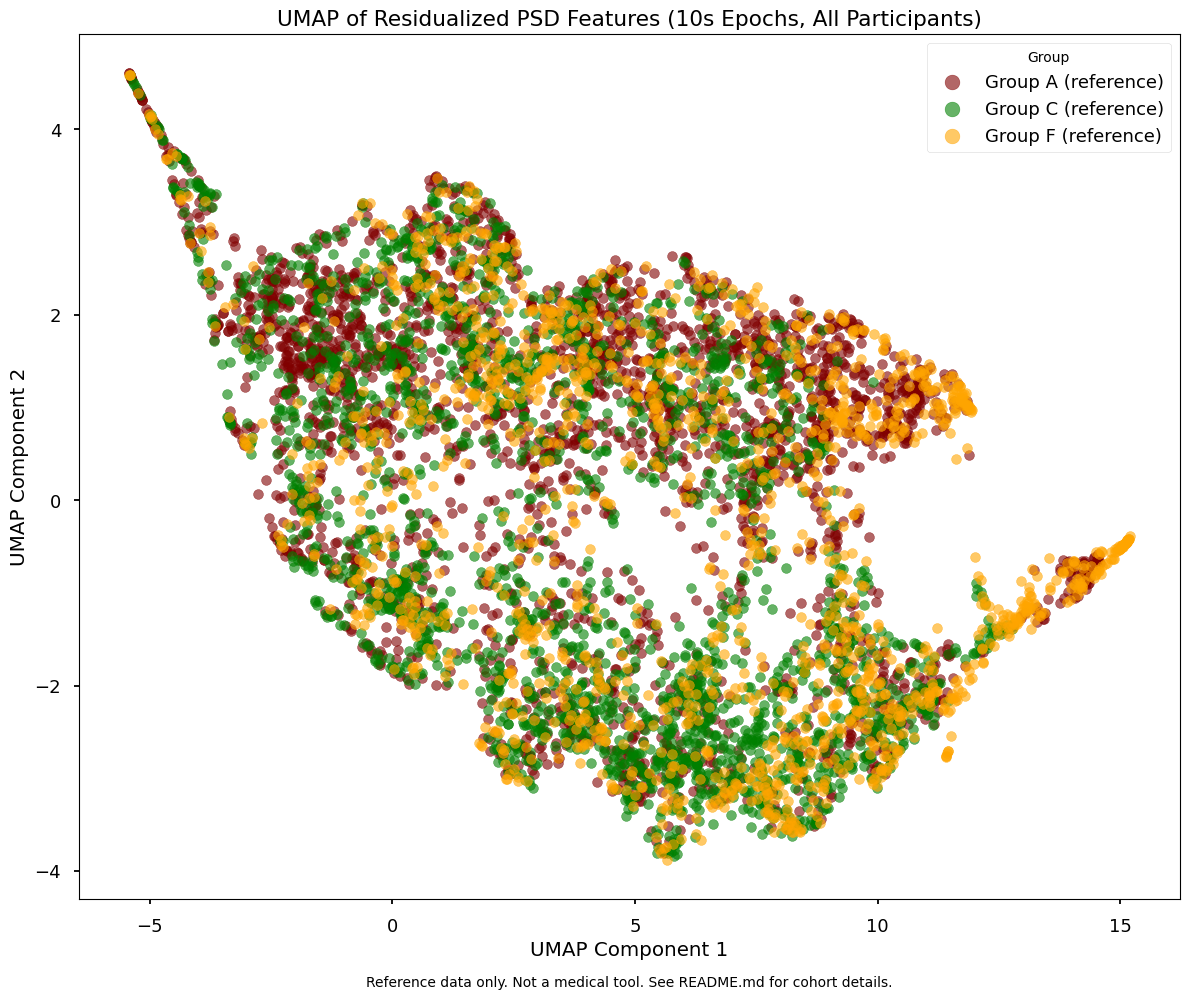

In [21]:
# Plot UMAP embedding with group labels
if 'embedding' in locals() and embedding is not None and embedding.shape[0] > 1:
    print("Plotting UMAP embedding of residualized PSD features...")
    plt.style.use('seaborn-v0_8-talk')
    fig_umap, ax = plt.subplots(figsize=(12, 10))
    group_map = {'A': 'Group A (reference)', 'F': 'Group F (reference)', 'C': 'Group C (reference)'}  # Neutral labels
    custom_color_map = {'A': 'maroon', 'F': 'orange', 'C': 'green'}  # Colors stay consistent
    unique_groups = sorted(np.unique(y_labels_psd))
    for group in unique_groups:
        mask = (y_labels_psd == group)
        ax.scatter(embedding[mask, 0], embedding[mask, 1],
                   c=custom_color_map.get(group, 'gray'),
                   label=group_map.get(group, group),
                   alpha=0.6, s=50)
    ax.set_title(f'UMAP of Residualized PSD Features ({epoch_length}s Epochs, All Participants)')
    ax.set_xlabel('UMAP Component 1')
    ax.set_ylabel('UMAP Component 2')
    plt.text(0.5, -0.1, 
         "Reference data only. Not a medical tool. See README.md for cohort details.",
         ha='center', transform=ax.transAxes, fontsize=10)
    ax.legend(title='Group', markerscale=1.5)
    plt.tight_layout()
    print("UMAP plot displayed inline")
else:
    print("Skipping UMAP plot: embedding not available or insufficient data.")